In [1]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
standard_amino_acids = list('AGILPVFWYDERHKSTCMNQ')

# loading reference set from spreadsheet provided by NM (from CPPsite2.0)
# then removing sequences containing any nonstandard-looking characters
import pandas as pd
path_to_spreadsheet = 'seed CPPs.xlsx'
initial_set = list(pd.read_excel(path_to_spreadsheet, sheetname=0, header=None)[0])
print('len(initial_set):', len(initial_set))
# remove redundancies
nonredundant_set = sorted(list(set(initial_set)))
print('len(nonredundant_set):', len(nonredundant_set))
# remove any sequences containing nonstandard characters (e.g. wildcards)
print('some peptides contained the following nonstandard characters:',
      sorted(list(set(list(''.join(nonredundant_set))).difference(standard_amino_acids))))
is_valid = lambda seq : (sum([aa in standard_amino_acids for aa in set(seq)]) / len(set(seq))) == 1
for seq in nonredundant_set:
    if not is_valid(seq):
        print('\t{}'.format(seq))
reference_set = [seq for seq in nonredundant_set if is_valid(seq)]
print('len(reference_set): ', len(reference_set))

len(initial_set): 1552
len(nonredundant_set): 1186
some peptides contained the following nonstandard characters: ['-', '5', '8', 'B', 'X', 'Z', 'f', 'h', 'm', 'x']
	AVPAKKRZKSV
	CGNVVRQGC-G-YGRK-KRRQRRR-G-TALDWSWLQTE
	CGRKKRRQR-Ahx-RRPPQ
	CGRKKRRQRR-Ahx-RPPQ
	CREKA-KKLFKKILKKL
	EEEEEEEEEE-PLGLAG-VSRRRRRRGGRRRR
	ELVVLGKL-YGRKKRRQRRR
	GRKKRRERRRPPERKCX
	HEHEHEHEHE-PEG-PLA
	HGWZIHGLLHRA
	ISF-R8-ELLDYY-S5-ED
	ISF-R8-ELLDYY-S5-ESGS
	ISF-R8-EWLQAY-S5-EDE
	LVVLGKL-YGRKKRRQRRR
	PKKKRKV-AGYLLGKINLKALAALAKKIL-PQMQQNVFQYPGAGMVPQGEANF
	PKKKRKV-RRRRRRR-PQMQQNVFQYPGAGMVPQGEANF
	PKKKRKV-RRRRRRR-YSQTSHKLVQLLTTAEQQ
	RGDfK
	RGRGRGRGRG-PEG-PLA
	RRRRRRRR-RGD
	SQMTRQARRLYBGC
	VVLGKL-YGRKKRRQRRR
	WE-YGRKKRRQRRR
	WEAVVA-YGRKKRRQRRR
	WEAVVL-YGRKKRRQRRR
	WEL-YGRKKRRQRRR
	WELV-YGRKKRRQRRR
	WELVV-YGRKKRRQRRR
	WELVVA-YGRKKRRQRRR
	WELVVL-YGRKKRRQRRR
	WELVVLG-YGRKKRRQRRR
	WELVVLGK-YGRKKRRQRRR
	WELVVLGKL-YGRKKRRQRRR
	YGRKKRRQRRR-C
	YKQCHKKGGXKKGSG
	mPEG-PLA-HEHEHEHEHE
	mPEG-PLA-RGRGRGRGRG
len(reference_set):  1149


In [25]:
from collections import defaultdict
from tqdm import tqdm

def count_kmers(sequences, k=3):
    kmer_counts = defaultdict(lambda : 0)
    for seq in tqdm(sequences):
        if len(seq) >= k:
            for i in range(len(seq) - k + 1):
                kmer_counts[seq[i:i+k]] += 1
    return kmer_counts

kmer_counts = count_kmers(reference_set, k=3)

100%|██████████| 1149/1149 [00:00<00:00, 197534.75it/s]


In [26]:
all_possible_3mers = []
for a in standard_amino_acids:
    for b in standard_amino_acids:
        for c in standard_amino_acids:
            all_possible_3mers.append(''.join([a,b,c]))

In [27]:
d = len(all_possible_3mers)
d

8000

In [28]:
index = dict(zip(all_possible_3mers, range(d)))

In [29]:
def project(sequence, k=3):
    vector = np.zeros(d)
    for i in range(len(sequence) - k + 1):
        vector[index[sequence[i:i+k]]] += 1
    return vector# / np.sum(vector)

In [30]:
%%time
project(reference_set[0])

CPU times: user 34 µs, sys: 8 µs, total: 42 µs
Wall time: 39.1 µs


array([1., 0., 0., ..., 0., 0., 0.])

In [31]:
kmer_projections = np.array(list(map(project, reference_set)))

In [32]:
kmer_projections.shape

(1149, 8000)

In [33]:
used_dims = (kmer_projections.sum(0) != 0)
sum(used_dims)

3259

In [34]:
X = kmer_projections[:,used_dims]

In [35]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

(0, 1)

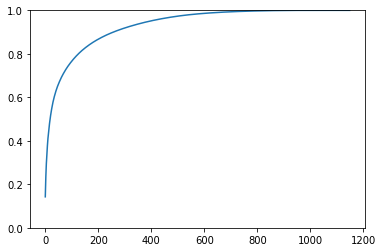

In [36]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylim(0,1)

In [37]:
Y = PCA(n_components=2).fit_transform(X)

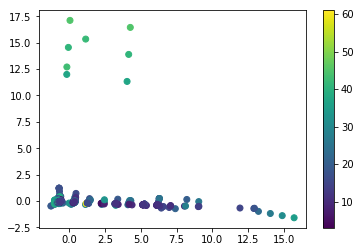

In [38]:
plt.scatter(Y[:,0], Y[:,1], c=list(map(len, reference_set)))
plt.colorbar()

In [39]:
%%time
np.linalg.norm(kmer_projections - project(reference_set[0]), axis=1)

CPU times: user 58.3 ms, sys: 56.7 ms, total: 115 ms
Wall time: 114 ms


array([0.        , 5.56776436, 4.69041576, ..., 6.78232998, 4.79583152,
       3.87298335])

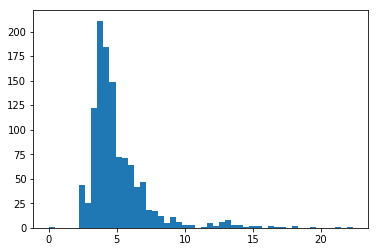

In [40]:
plt.hist(np.linalg.norm(kmer_projections - project(reference_set[0]), axis=1), bins=50);

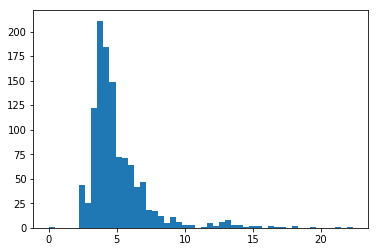

In [41]:
plt.hist(np.linalg.norm(kmer_projections - project(reference_set[0]), axis=1), bins=50);

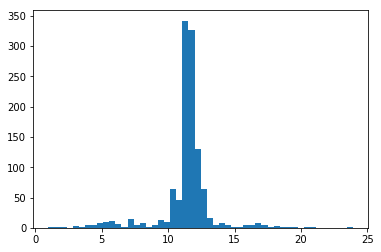

In [42]:
plt.hist(np.linalg.norm(kmer_projections - project('RRRRRRRRRRRRR'), axis=1), bins=50);

In [43]:
from scipy.special import logsumexp
def score(peptide, sigma=1.0):
    distances = np.linalg.norm(kmer_projections - project(peptide), axis=1)
    return -logsumexp((distances/sigma**2)**2)

In [44]:
project('AAA').shape

(8000,)

In [45]:
for _ in range(10):
    print('{:.5}'.format(score(reference_set[np.random.randint(len(reference_set))])))

-526.0
-485.0
-506.0
-508.0
-501.0
-517.0
-557.0
-533.0
-441.0
-505.0


In [46]:
print('{:.5}'.format(score('AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA')))

-1395.0


In [47]:
%%time
score('AAA')

CPU times: user 40 ms, sys: 11.7 ms, total: 51.7 ms
Wall time: 50.1 ms


-495.99999999999994

In [48]:
def symmetric_one_site_mutate(sequence_string):
    ind_to_mutate = np.random.randint(len(sequence_string))
    residue_to_insert = standard_amino_acids[np.random.randint(len(standard_amino_acids))]
    
    sequence_as_list = list(sequence_string)
    sequence_as_list[ind_to_mutate] = residue_to_insert
    return ''.join(sequence_as_list)

def random_deletion(sequence_string, min_length=3):
    """if deleting a residue won't make the string too short, delete a position at random"""
    if len(sequence_string) <= min_length + 1:
        return sequence_string
    ind_to_delete = np.random.randint(len(sequence_string))
    sequence_as_list = list(sequence_string)
    sequence_as_list[ind_to_delete] = ''
    return ''.join(sequence_as_list)


def random_insertion(sequence_string, max_length=60):
    """if inserting a residue won't make the string too long, insert a residue at random"""
    if len(sequence_string) >= max_length - 1:
        return sequence_string
    
    residue_to_insert = standard_amino_acids[np.random.randint(len(standard_amino_acids))]
    ind_to_insert = np.random.randint(len(sequence_string) + 1)
    sequence_as_list = list(sequence_string)
    sequence_as_list.insert(ind_to_insert, residue_to_insert)
    return ''.join(sequence_as_list)

moves = [symmetric_one_site_mutate, random_deletion, random_insertion]

def almost_symmetric_one_site_move(sequence_string):
    return moves[np.random.randint(len(moves))](sequence_string)

In [49]:
def random_walk_mh(x0, log_prob_func, symmetric_proposal_func, n_steps=1000):
    """Random-walk Metropolis-Hastings
    
    Parameters
    ----------
    x0 : object
        initial state of sampler
    log_prob_func : callable, accepts an object like x0 and returns a float
        unnormalized log probability density function
    symmetric_proposal_func : callable, accepts an object like x0 and returns another object like x0
        assume this samples from a symmetric proposal distribution (p(y|x) = p(x|y))
    n_steps : integer
        number of MCMC steps
    
    Returns
    -------
    traj : [n_steps + 1] list of objects
        trajectory of samples generated by MCMC
    log_probs : [n_steps + 1] array of floats
        unnormalized log-probabilities of the samples
    acceptance_fraction : float in [0,1]
        fraction of accepted proposals
    """
    traj = [x0]
    log_probs = [log_prob_func(x0)]

    acceptances = 0
    r = range(n_steps)
    trange = tqdm(r)
    for n in trange:

        x_proposal = symmetric_proposal_func(traj[-1])
        log_prob_proposal = log_prob_func(x_proposal)

        if np.random.rand() < np.exp(log_prob_proposal - log_probs[-1]):
            traj.append(x_proposal)
            log_probs.append(log_prob_proposal)
            acceptances += 1
        else:
            traj.append(traj[-1])
            log_probs.append(log_probs[-1])

        trange.set_postfix({
            'log_prob': log_probs[-1],
            'accept_fraction': float(acceptances) / (1 + n),
            'len(peptide)': len(traj[-1]),
            'peptide': traj[-1]
        })
    del (trange)

    return traj, np.array(log_probs), float(acceptances) / n_steps

In [50]:
x0 = 'GRKKRRQRRRPQ' # TAT sequence
len(x0)

12

In [51]:
np.random.seed(0)
peptides, scores, acceptance_rate = random_walk_mh(x0,
               log_prob_func=lambda peptide : score(peptide, sigma=0.5),
               symmetric_proposal_func=almost_symmetric_one_site_move,
               n_steps=1000,
              )

100%|██████████| 1000/1000 [01:00<00:00, 16.57it/s, log_prob=-7.26e+03, accept_fraction=0.374, len(peptide)=4, peptide=RRRR]     


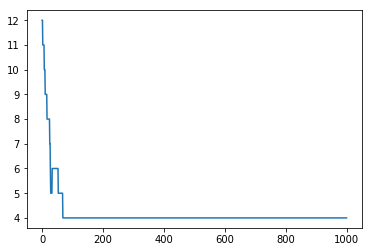

In [52]:
plt.plot(list(map(len, peptides)))

In [53]:
unique_peptides = sorted(list(set(peptides)))
len(unique_peptides)

25

In [86]:
np.random.seed(0)
peptides, scores, acceptance_rate = random_walk_mh(x0,
               log_prob_func=lambda peptide : score(peptide, sigma=1.4),
               symmetric_proposal_func=almost_symmetric_one_site_move,
               n_steps=500000,
              )

100%|██████████| 500000/500000 [7:18:04<00:00, 19.02it/s, log_prob=-131, accept_fraction=0.54, len(peptide)=10, peptide=LTMHMAADYE]                                                   


In [87]:
sampled_lengths = np.array(list(map(len, peptides)))

Text(0.5,0,'MCMC iteration')

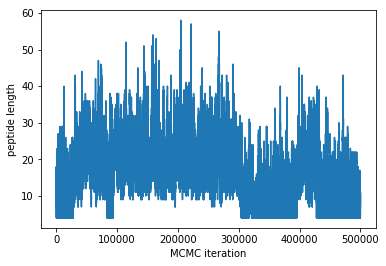

In [88]:
plt.plot(sampled_lengths)
plt.ylabel('peptide length')
plt.xlabel('MCMC iteration')

(array([112388., 107867., 134396.,  75658.,  39025.,  20861.,   5977.,
          2901.,    769.,    159.]),
 array([ 4. ,  9.4, 14.8, 20.2, 25.6, 31. , 36.4, 41.8, 47.2, 52.6, 58. ]),
 <a list of 10 Patch objects>)

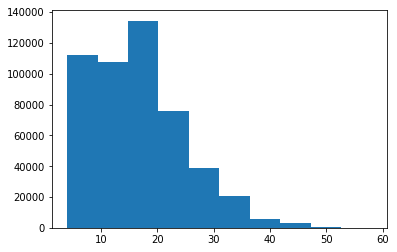

In [89]:
plt.hist(sampled_lengths)

In [90]:
with open('peptide_traj.txt', 'w') as f:
    f.writelines(['{}\n'.format(p) for p in peptides])

In [91]:
unique_peptides = sorted(list(set(peptides)))
unique_peptides[:5]

['AAAAHHHEY', 'AAACHHHEWE', 'AAAHHHEE', 'AAAHHHEWE', 'AAAHHHEY']

In [92]:
with open('unique_peptides.txt', 'w') as f:
    f.writelines(['{}\n'.format(p) for p in unique_peptides])

In [93]:
len(unique_peptides)

240767

In [94]:
set(unique_peptides).intersection(set(reference_set)), len(set(unique_peptides).intersection(set(reference_set)))

({'GRKKRRQRRRPQ', 'RRRR', 'RRRRR'}, 3)

In [79]:
x0

'GRKKRRQRRRPQ'